## CMPN403 Programming Assignment
Team:
- Yomna Osama Hussien 1190203
- Mohamed Hassan Mohamed 1190118

In [10]:
import re
import json
import graphviz
from typing import *
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Utility functions

In [11]:
def verify_regex(regex: str) -> bool:
    try:
        re.compile(regex)
        return True
    except re.error:
        return False
    
def get_subregex(regex: str, i: int) -> str:
        depth = 1
        subregex = regex[i+1:]
        for j in range(len(subregex)):
            if subregex[j] == '(':
                depth += 1
            elif subregex[j] == ')':
                depth -= 1
            if depth == 0:
                subregex = subregex[:j]
                break
        return subregex

def json_write(states: Dict[str, Dict], filename: str) -> None:
    if not filename.endswith('.json'):
        filename += '.json'
        
    with open(filename, 'w') as file:
        json.dump(states, file, indent=4)

def draw_nfa(json_file: str) -> graphviz.Digraph:
    with open(json_file, 'r') as file:
        nfa: Dict[str, Dict] = json.load(file)

    dot = graphviz.Digraph(comment='NFA')

    # add invisible starting state
    dot.node('startingStateH', 'startingStateH', style='invis')
    
    # add nodes
    for key in nfa.keys():
        if key == 'startingState':
            continue
        if nfa[key]['isTerminatingState']:
            dot.node(key, key, shape='doublecircle')
        else:
            dot.node(key, key)
    
    # add edges
    for key in nfa.keys():
        if key == 'startingState':
            continue
        for symbol in nfa[key].keys():
            if symbol == 'isTerminatingState':
                continue
            for next_state in nfa[key][symbol]:
                sy = symbol
                if symbol == 'epsilon':
                    sy = 'ε'
                dot.edge(key, next_state, label=sy)
    
    dot.edge('startingStateH', nfa['startingState'])

    return dot

def display_and_save_image(json_file: str, fileName: str) -> None:
    dot = draw_nfa(json_file)
    dot.format = 'png'
    dot.render(fileName)
    
    img = mpimg.imread(fileName+'.png')
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.figure(figsize=(15, 15))
    plt.show()

### Regex to NFA

In [41]:
class NFA:
    def __init__(self) -> None:
        self.start_state = 0
        self.next_state = 0
        self.prev_state = 0
        self.prev_start = 0
        self.states = {"startingState": "S0", "S0": {"isTerminatingState": False}}

    def generate_NFA(self, regex: str, filename: str) -> None:
        if not verify_regex(regex):
            print("Invalid regex")
            return

        i = self.build_NFA(regex)
        
        if i == len(regex):
            self.states["S" + str(self.next_state)]["isTerminatingState"] = True
            self.states.update({"startingState": ("S" + str(self.prev_start))})

        json_write(self.states, filename)
    
    def build_NFA(self, regex: str) -> int:
        i = 0
        while i < len(regex):
            if regex[i] == '(':
                subregex = get_subregex(regex, i)

                start_state = self.start_state
                next_state = self.next_state
                prev_state = self.prev_state
                prev_start = self.prev_start

                sub_value = self.next_state + 1
                self.start_state = sub_value
                self.next_state = sub_value
                self.prev_state = sub_value
                self.prev_start = sub_value

                self.states.update({"S" + str(self.next_state): {"isTerminatingState": False}})
                self.build_NFA(subregex)

                if "ε" in self.states["S" + str(next_state)].keys():
                    self.states["S" + str(next_state)]["ε"].append("S" + str(self.prev_start))
                else:
                    self.states["S" + str(next_state)]["ε"] = ["S" + str(self.prev_start)]

                self.prev_state = self.prev_start
                self.prev_start = prev_start
                self.start_state = self.next_state

                i += len(subregex) + 2
                
            elif regex[i] == '|':
                i += 1

                self.states.update({"S" + str(self.next_state + 1): {"isTerminatingState": False}})

                start_state = self.start_state
                next_state = self.next_state
                prev_state = self.prev_state
                prev_start = self.prev_start

                alt_value = self.next_state + 1
                self.start_state = alt_value
                self.next_state = alt_value
                self.prev_state = alt_value
                self.prev_start = alt_value
                
                self.build_NFA(regex[i:])

                alt_start_state = self.start_state
                alt_next_state = self.next_state
                alt_prev_state = self.prev_state
                alt_prev_start = self.prev_start

                self.start_state = start_state
                self.next_state = next_state
                self.prev_state = prev_state
                self.prev_start = prev_start

                i += len(regex[i:])

                self.states.update({"S" + str(alt_next_state + 1): {"isTerminatingState": False}})
                
                if 'ε' in self.states["S" + str(alt_next_state + 1)].keys():
                    self.states["S" + str(alt_next_state + 1)]["ε"].append("S" + str(self.prev_start))
                    self.states["S" + str(alt_next_state + 1)]["ε"].append("S" + str(alt_prev_start))
                else:
                    self.states["S" + str(alt_next_state + 1)]["ε"] = ["S" + str(self.prev_start), "S" + str(alt_prev_start)]

                self.states.update({"S" + str(alt_next_state + 2): {"isTerminatingState": False}}) 

                if 'ε' in self.states["S" + str(alt_next_state)].keys():
                    self.states["S" + str(alt_next_state)]["ε"].append("S" + str(alt_next_state + 2))
                else:
                   self.states["S" + str(alt_next_state)]["ε"] = ["S" + str(alt_next_state + 2)]

                if 'ε' in self.states["S" + str(self.next_state)].keys():
                    self.states["S" + str(self.next_state)]["ε"].append("S" + str(alt_next_state + 2))
                else:
                    self.states["S" + str(self.next_state)]["ε"] = ["S" + str(alt_next_state + 2)] 

                self.prev_start = alt_next_state + 1
                self.next_state = alt_next_state + 2
                self.prev_state = alt_next_state + 1
                self.start_state = alt_next_state
            elif regex[i] == '[':
                substring, end = self.get_range_substring(regex, i)
                self.start_state, self.next_state, self.prev_state, self.states = self.add_state(substring, self.start_state, self.next_state, self.prev_state, self.states, i, True)
                i = end 

            else:
                self.start_state, self.next_state, self.prev_state, self.states = self.add_state(regex, self.start_state, self.next_state, self.prev_state, self.states, i)
                i += 1
        return i
    
    def add_state(self, regex: str, start_state: int, next_state: int,prev_state: int, states: Dict[str, Dict], i: int, isRange: bool = False) -> Tuple[int, int, Dict[str, Dict]]:
        next_state += 1
        if isRange:
            return self.handleRange(start_state, next_state, prev_state, states, regex)
        
        if(regex[i] == '+'):
            return self.handlePositiveClosure(start_state, next_state, prev_state, states)
        
        if regex[i] == '*':
            return self.handleZeroOrMore(start_state, next_state, prev_state, states)
        
        if regex[i] == '?':
           return self.handleZeroOrOne(start_state, next_state, prev_state, states)
        
        if regex[i] in states["S" + str(start_state)]:
            states["S" + str(start_state)][regex[i]].append("S" + str(next_state))
        else:
            states["S" + str(start_state)][regex[i]] = ["S" + str(next_state)]
        
        states["S" + str(next_state)] = {"isTerminatingState": False}
        prev_state = start_state
        start_state = next_state

        return start_state, next_state, prev_state, states

    def get_range_substring(self, regex: str, i: int) -> Tuple[str, int]:
        subString = ""
        end = i
        regex = regex[i:]       # discard part before bracket (but takes the bracket itself)
        for j in range(len(regex)):
            if regex[j] == ']':             # matching first closed bracket
                subString = regex[:j+1]       # discard part after bracket (but takes the bracket itself)
                end = i+j+1
                return subString, end
        
        return subString, end

    def handleRange(self, start_state: int, next_state: int, prev_state: int, states: Dict[str, Dict], substring: str) -> Tuple[int, int,int, Dict[str, Dict]]:
        if substring in states["S" + str(start_state)].keys():
            states["S" + str(start_state)][substring].append("S" + str(next_state))
        else:
            states["S" + str(start_state)][substring] = ["S" + str(next_state)]
        
        states["S" + str(next_state)] = {"isTerminatingState": False}
        prev_state = start_state
        start_state = next_state

        return start_state, next_state, prev_state, states

    def handlePositiveClosure(self, start_state: int, next_state: int, prev_state: int, states: Dict[str, Dict]) -> Tuple[int, int,int, Dict[str, Dict]]:
        states["S" + str(next_state)] = {"isTerminatingState": False}  
        if 'ε' in states["S" + str(start_state)]:
            states["S" + str(start_state)]["ε"].append("S" + str(prev_state))
            states["S" + str(start_state)]["ε"].append("S" + str(next_state))
        else:
            states["S" + str(start_state)]["ε"] = ["S" + str(prev_state), "S" + str(next_state)]
        prev_state = start_state
        start_state = next_state
        return start_state, next_state, prev_state, states
    
    def handleZeroOrMore(self, start_state: int, next_state: int, prev_state: int, states: Dict[str, Dict]) -> Tuple[int, int,int, Dict[str, Dict]]:
        states["S" + str(next_state)] = {"isTerminatingState": False}  
        if 'ε' in states["S" + str(start_state)]:
            states["S" + str(start_state)]["ε"].append("S" + str(prev_state))
            states["S" + str(start_state)]["ε"].append("S" + str(next_state))
        else:
            states["S" + str(start_state)]["ε"] = ["S" + str(prev_state), "S" + str(next_state)]
        
        if 'ε' in states["S" + str(prev_state)]:
            states["S" + str(prev_state)]["ε"].append("S" + str(next_state))
        else:
            states["S" + str(prev_state)]["ε"] = ["S" + str(next_state)]
            
        prev_state = start_state
        start_state = next_state
        return start_state, next_state, prev_state, states
    
    def handleZeroOrOne(self, start_state: int, next_state: int, prev_state: int, states: Dict[str, Dict]) -> Tuple[int, int,int, Dict[str, Dict]]:
        states["S" + str(next_state)] = {"isTerminatingState": False}  
        if 'ε' in states["S" + str(start_state)]:
            states["S" + str(start_state)]["ε"].append("S" + str(next_state))
        else:
            states["S" + str(start_state)]["ε"] = ["S" + str(next_state)]
        
        if 'ε' in states["S" + str(prev_state)]:
            states["S" + str(prev_state)]["ε"].append("S" + str(next_state))
        else:
            states["S" + str(prev_state)]["ε"] = ["S" + str(next_state)]
        
        prev_state = start_state
        start_state = next_state
        return start_state, next_state, prev_state, states

#### Functional Testing

In [ ]:
nfa = NFA()
nfa.generate_NFA("yomna", "literal.json")
display_and_save_image("literal.json", "literal")

In [ ]:
nfa = NFA()
nfa.generate_NFA("amin+", "positiveClosure.json")
display_and_save_image("positiveClosure.json", "positiveClosure")

In [ ]:
nfa = NFA()
nfa.generate_NFA("amin?", "zeroOrOne.json")
display_and_save_image("zeroOrOne.json", "zeroOrOne")

In [ ]:
nfa = NFA()
nfa.generate_NFA("amin*", "zeroOrMore.json")
display_and_save_image("zeroOrMore.json", "zeroOrMore")

In [ ]:
nfa = NFA()
nfa.generate_NFA("aa|b", "Alternate.json")
display_and_save_image("Alternate.json", "Alternate")

In [ ]:
nfa = NFA()
nfa.generate_NFA("[A-Z0-9]", "range.json")
display_and_save_image("range.json", "range")

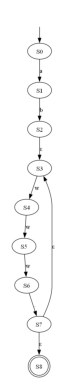

<Figure size 1500x1500 with 0 Axes>

In [44]:
nfa = NFA()
nfa.generate_NFA("ab(www.)+", "brackets.json")
display_and_save_image("brackets.json", "brackets")

#### NFA Testing

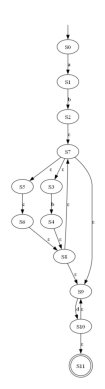

<Figure size 1500x1500 with 0 Axes>

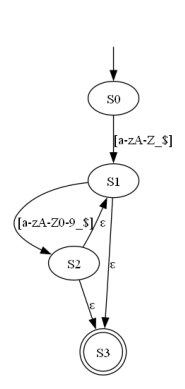

<Figure size 1500x1500 with 0 Axes>

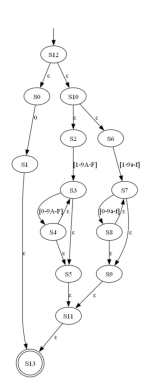

<Figure size 1500x1500 with 0 Axes>

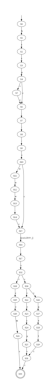

<Figure size 1500x1500 with 0 Axes>

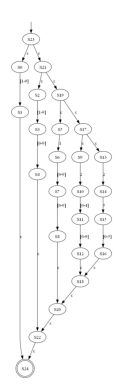

<Figure size 1500x1500 with 0 Axes>

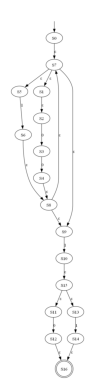

<Figure size 1500x1500 with 0 Axes>

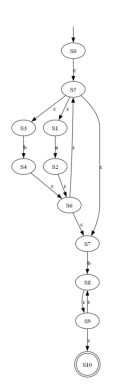

<Figure size 1500x1500 with 0 Axes>

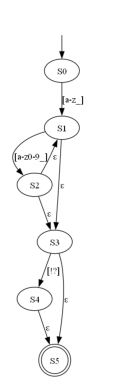

<Figure size 1500x1500 with 0 Axes>

In [45]:
# Testcases
test1 = "ab(b|c)*d+"
test2 = "[a-zA-Z_$][a-zA-Z0-9_$]*"
test3 = "0|[1-9A-F][0-9A-F]*|[1-9a-f][0-9a-f]*"
test4 = "https?://(www.)?[a-zA-Z0-9-_].(com|org|net)"
test5 = "[1-9]|[1-9][0-9]|1[0-9][0-9]|2[0-4][0-9]|25[0-5]"
test6 = "((00)|1)*1(0|1)"
test7 = "(a|b)*bc+"
test8 = "[a-z_][a-z0-9_]*[!?]?"

nfa = NFA()
nfa.generate_NFA(test1, "test1.json")
display_and_save_image("test1.json", "test1")


nfa = NFA()
nfa.generate_NFA(test2, "test2.json")
display_and_save_image("test2.json", "test2")


nfa = NFA()
nfa.generate_NFA(test3, "test3.json")
display_and_save_image("test3.json", "test3")


nfa = NFA()
nfa.generate_NFA(test4, "test4.json")
display_and_save_image("test4.json", "test4")


nfa = NFA()
nfa.generate_NFA(test5, "test5.json")
display_and_save_image("test5.json", "test5")


nfa = NFA()
nfa.generate_NFA(test6, "test6.json")
display_and_save_image("test6.json", "test6")


nfa = NFA()
nfa.generate_NFA(test7, "test7.json")
display_and_save_image("test7.json", "test7")


nfa = NFA()
nfa.generate_NFA(test8, "test8.json")
display_and_save_image("test8.json", "test8")